# CNN Predictive Model — Revised (Flips like Box 4)

This version **keeps your original imports, initial visualization, and classification labels**, and adds a preprocessing block that *mimics your Box 4*:

- **Train:** `RandomCrop(178)` → `RandomHorizontalFlip()` → `Resize(64)` → `ToTensor()`
- **Eval:**  `CenterCrop(178)` → `Resize(64)` → `ToTensor()`

We set `num_workers=0` for compatibility on macOS/Windows.

## Imports (kept as-is)

In [13]:
pip install pillow pillow-heif



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
#Import Required libraries
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [15]:
import pathlib
from PIL import Image, ImageOps

# Try enabling AVIF/HEIC decoding
try:
    from pillow_heif import register_heif_opener
    register_heif_opener()
    print("✅ AVIF/HEIC support enabled via pillow-heif")
except Exception:
    print("⚠️ AVIF/HEIC support not installed. Run: pip install pillow-heif")

# Path to your images
imgdir_path = pathlib.Path(r"/Users/bradyhill/Downloads/Final Project 3 Data")

# Allowable formats
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".avif", ".heic", ".tif", ".tiff", ".bmp"}
SKIP_BASENAMES = {".ds_store", "thumbs.db"}

converted = 0
skipped = 0
errors = 0

# --- STEP 1: Convert everything non-JPG to JPG ---
for img_path in imgdir_path.iterdir():
    if not img_path.is_file():
        continue

    name_lower = img_path.name.lower()
    if name_lower in SKIP_BASENAMES or name_lower.startswith("."):
        continue

    ext = img_path.suffix.lower()
    if ext not in ALLOWED_EXTS:
        continue

    if ext in {".jpg", ".jpeg"}:
        skipped += 1
        continue

    new_path = img_path.with_suffix(".jpg")

    try:
        with Image.open(img_path) as im:
            im = ImageOps.exif_transpose(im)
            if im.mode not in ("RGB", "L"):
                im = im.convert("RGB")
            im.save(new_path, "JPEG", quality=92, optimize=True, progressive=True)
        img_path.unlink()  # remove original
        converted += 1
        print(f"Converted and removed {img_path.name} -> {new_path.name}")
    except Exception as e:
        errors += 1
        print(f"Failed to convert {img_path.name}: {e}")

# --- STEP 2: Collect all JPGs ---
file_list = sorted(imgdir_path.glob("*.jpg"))
file_list = [str(p) for p in file_list]

# --- STEP 3: Count how many are 'Negative' ---
negative_count = sum(1 for p in file_list if pathlib.Path(p).stem.lower().startswith("negative"))
razorback_count = sum(1 for p in file_list if pathlib.Path(p).stem.lower().startswith("razorback"))
other_count = len(file_list) - negative_count - razorback_count

# --- STEP 4: Print results ---
print("\n--- Conversion Summary ---")
print(f"Converted: {converted}")
print(f"Skipped:   {skipped}")
print(f"Errors:    {errors}")
print(f"Total JPGs: {len(file_list)}")
print(f"Negative images: {negative_count}")
print(f"Razorback images: {razorback_count}")
print(f"Other images: {other_count}")


✅ AVIF/HEIC support enabled via pillow-heif

--- Conversion Summary ---
Converted: 0
Skipped:   80
Errors:    0
Total JPGs: 80
Negative images: 40
Razorback images: 40
Other images: 0


## File listing (kept if present)

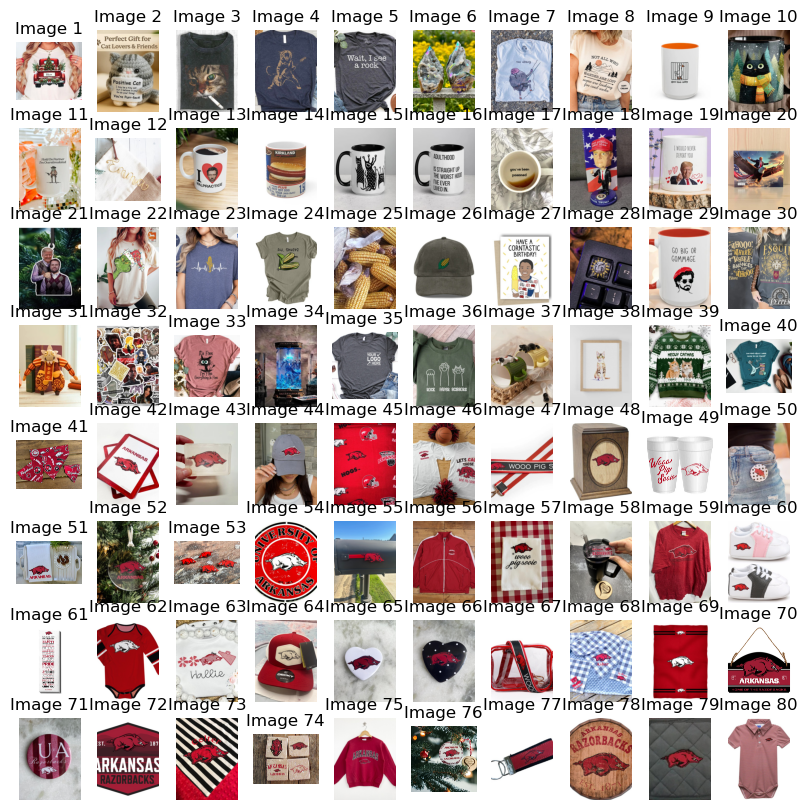

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

# Let's say you want to plot the first 4 images
num_images = 80

plt.figure(figsize=(10, 10))  # Set the figure size

for i, img_path in enumerate(file_list[:num_images]):
    img = Image.open(img_path)  # Open the image
    plt.subplot(8, 10, i + 1)   # Create a 2x2 grid
    plt.imshow(img)             # Show the image
    plt.axis('off')             # Hide the axes
    plt.title(f"Image {i+1}")  # Optional title

plt.show()

## Classification labels (kept as-is)

In [17]:
# pull labels from file names and create label scheme
labels = [0 if 'Negative' in os.path.basename(file) else 1
          for file in file_list]
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Initial visualization (kept as-is)

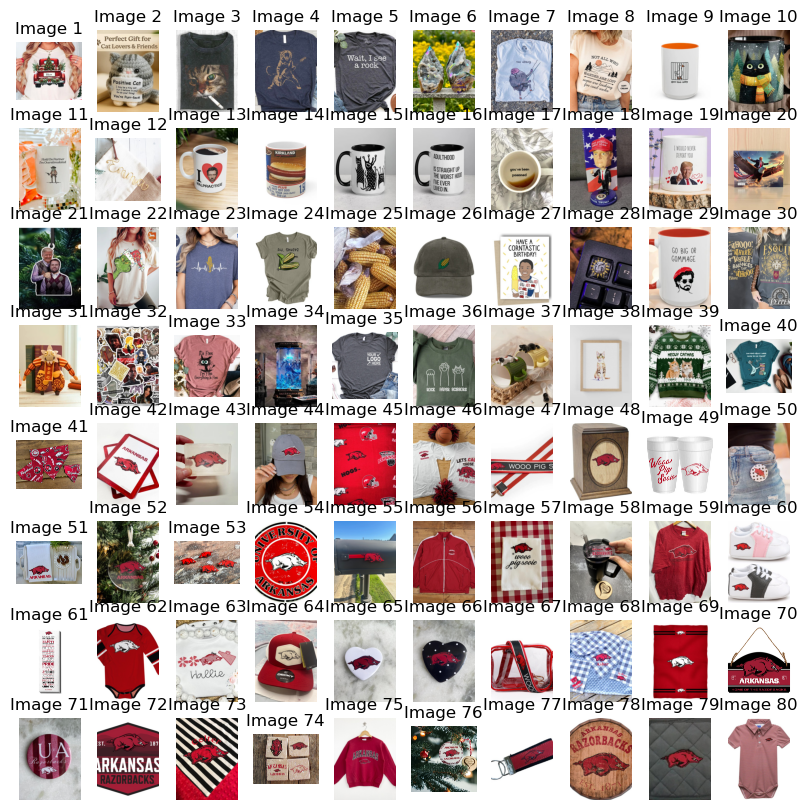

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

# Let's say you want to plot the first 4 images
num_images = 80

plt.figure(figsize=(10, 10))  # Set the figure size

for i, img_path in enumerate(file_list[:num_images]):
    img = Image.open(img_path)  # Open the image
    plt.subplot(8, 10, i + 1)   # Create a 2x2 grid
    plt.imshow(img)             # Show the image
    plt.axis('off')             # Hide the axes
    plt.title(f"Image {i+1}")  # Optional title

plt.show()

In [19]:

## Preprocessing & DataLoaders — Box 4 style (train flips)

from pathlib import Path
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms

SEED       = 1
BATCH_SIZE = 16
torch.manual_seed(SEED)
random.seed(SEED)

# Expect original 'file_list' and 'labels' from your kept cells
try:
    _ = file_list
    _ = labels
except NameError as e:
    raise RuntimeError("This cell expects 'file_list' and 'labels' to be defined above.") from e

# Dataset
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels    = labels
        self.transform = transform
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, self.labels[idx]

# --- Box 4 mimic transforms ---
# Train: RandomCrop(178) -> RandomHorizontalFlip() -> Resize(64) -> ToTensor()
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([500, 500]),
    transforms.ToTensor(),
])

# Eval: CenterCrop(178) -> Resize(64) -> ToTensor()
transform_eval = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([500, 500]),
    transforms.ToTensor(),
])

# Split
n = len(file_list)
n_train = int(0.8 * n)
n_val   = n - n_train
indices = list(range(n))
gen = torch.Generator().manual_seed(SEED)
train_idx, val_idx = random_split(indices, [n_train, n_val], generator=gen)
train_idx = train_idx.indices if hasattr(train_idx, 'indices') else train_idx
val_idx   = val_idx.indices   if hasattr(val_idx, 'indices')   else val_idx

train_files  = [file_list[i] for i in train_idx]
train_labels = [labels[i]    for i in train_idx]
val_files    = [file_list[i] for i in val_idx]
val_labels   = [labels[i]    for i in val_idx]

train_ds = ImageDataset(train_files, train_labels, transform=transform_train)
val_ds   = ImageDataset(val_files,   val_labels,   transform=transform_eval)

# Use num_workers=0 for notebook safety (macOS/Windows spawn)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
valid_dl = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train: {len(train_ds)} | Valid: {len(val_ds)}")


Train: 64 | Valid: 16


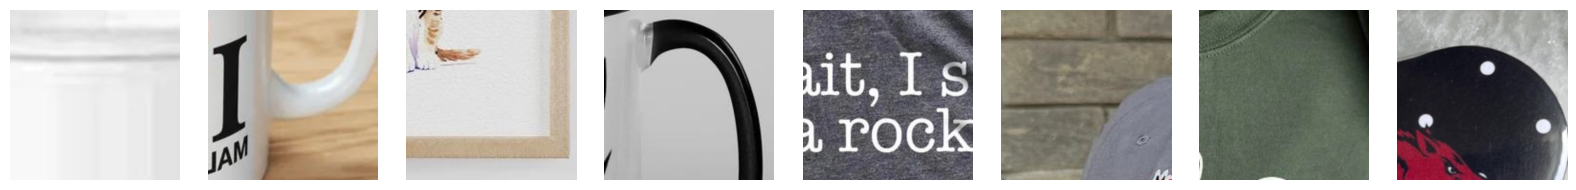

In [20]:

## Quick preview (optional): visualize a batch
import matplotlib.pyplot as plt
import torch

images, targets = next(iter(train_dl))
cols = min(8, images.size(0))
fig, axes = plt.subplots(1, cols, figsize=(cols*2, 2))
for i in range(cols):
    img = images[i].detach().cpu()
    img = img.permute(1, 2, 0).clamp(0, 1)  # no normalize in this Box 4 mimic
    axes[i].imshow(img)
    axes[i].axis("off")
plt.tight_layout()
plt.show()


## Added: PyTorch CNN model (3-channel)
_Appended on 2025-11-20T20:03:15_

The following cell defines the PyTorch model you requested. Everything else in the notebook is unchanged.


In [21]:
# ✅ Minimal, robust fix for 500×500 inputs:
# Insert an AdaptiveAvgPool2d((8,8)) BEFORE Flatten so the linear layer stays 256*8*8.
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),

    nn.Conv2d(128, 256, 3, padding=1),
    nn.LeakyReLU(0.1),

    # 👇 Added: makes final feature map exactly 8x8 regardless of input size (e.g., 500x500)
    nn.AdaptiveAvgPool2d((8, 8)),

    nn.Flatten(),
    nn.Linear(256 * 8 * 8, 128),
    nn.LeakyReLU(0.1),
    nn.Dropout(0.2),
    nn.Linear(128, 1)  # single logit for BCEWithLogitsLoss
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fn  = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [22]:
# ==== PATCH: imbalance handling + stability tweaks (paste AFTER model creation, BEFORE training) ====
import math, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 1) Class counts from your existing `labels` list (0/1 ints)
labels_np = np.array(labels)
num_pos = int((labels_np == 1).sum())
num_neg = int((labels_np == 0).sum())
total   = num_pos + num_neg
print(f"class 0: {num_neg} | class 1: {num_pos}")

# 2) Weighted loss for imbalance (BCEWithLogitsLoss)
#    pos_weight = NEG/POS so positives are up-weighted when rare
pos_weight = torch.tensor([ (num_neg / max(num_pos, 1)) ], dtype=torch.float32, device=device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 3) Reduce regularization and LR for small data
#    Lower all Dropouts to 0.2 (keeps your architecture intact)
for m in model.modules():
    if isinstance(m, nn.Dropout):
        m.p = 0.2

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 4) Bias init of the last linear layer to match prior p(y=1)
#    Works if your last layer is model[-1] and is nn.Linear with out_features == 1
p = num_pos / total if total > 0 else 0.5
with torch.no_grad():
    if isinstance(model[-1], nn.Linear) and model[-1].out_features == 1:
        if 0.0 < p < 1.0:
            model[-1].bias.fill_(math.log(p/(1.0-p)))
        else:
            model[-1].bias.zero_()

print("pos_weight:", pos_weight.item(), "| dropout set to 0.2 | lr=1e-4 | bias initialized to prior")

# 5) (OPTIONAL) Rebalance batches with a WeightedRandomSampler for training
#    Use only if classes are quite imbalanced. Rebuild train_dl with this sampler.
USE_SAMPLER = (min(num_pos, num_neg) / max(num_pos, num_neg) < 0.7)  # heuristic
if USE_SAMPLER:
    # Build sample-level weights aligned with your train indices, not full labels
    # We map train_ds targets from your earlier split
    train_targets = np.array(train_labels)  # already aligned to train_files
    w_pos = num_neg / total
    w_neg = num_pos / total
    sample_weights = [w_pos if y==1 else w_neg for y in train_targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Recreate train_dl with sampler (keep valid_dl the same)
    # (Reuse your BATCH_SIZE; num_workers=0 for notebook safety)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=False)
    print("Using WeightedRandomSampler for balanced batches.")
# ==== END PATCH ====


class 0: 40 | class 1: 40
pos_weight: 1.0 | dropout set to 0.2 | lr=1e-4 | bias initialized to prior


In [23]:
def train(model, num_epochs, train_dl, valid_dl):
    """
    Trains a binary CNN that outputs a single logit per sample.
    Returns per-epoch mean losses and accuracies for train/valid.
    """
    loss_hist_train  = [0.0] * num_epochs
    accuracy_hist_train = [0.0] * num_epochs
    loss_hist_valid  = [0.0] * num_epochs
    accuracy_hist_valid = [0.0] * num_epochs

    for epoch in range(num_epochs):
        # put dropout/batchnorm in training mode
        model.train()

        for x_batch, y_batch in train_dl:
            # move data to device (GPU/CPU)
            x_batch = x_batch.to(device)
            y_batch = y_batch.float().to(device)  # BCE wants float targets in {0.0, 1.0}

            # forward: raw logits (no sigmoid here)
            pred_logit = model(x_batch).squeeze(1)   # [B,1] -> [B]

            # loss between logits and 0/1 targets
            loss = loss_fn(pred_logit, y_batch)

            # backprop + update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # accumulate loss (sum) and accuracy (threshold at 0.5)
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            preds_bin = (pred_logit >= 0).float()    # logit>=0 ↔ sigmoid>=0.5
            accuracy_hist_train[epoch] += (preds_bin == y_batch).sum().item()

        # average over dataset size
        loss_hist_train[epoch]     /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # evaluation mode (turns off dropout)
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.float().to(device)

                pred_logit = model(x_batch).squeeze(1)
                loss = loss_fn(pred_logit, y_batch)

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                preds_bin = (pred_logit >= 0).float()
                accuracy_hist_valid[epoch] += (preds_bin == y_batch).sum().item()

        loss_hist_valid[epoch]     /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f"Epoch {epoch+1:02d} "
              f"acc={accuracy_hist_train[epoch]:.4f} val_acc={accuracy_hist_valid[epoch]:.4f} "
              f"| loss={loss_hist_train[epoch]:.4f} val_loss={loss_hist_valid[epoch]:.4f}")

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [24]:
num_epochs = 50
print("Starting training...")
loss_train, loss_val, acc_train, acc_val = train(model, num_epochs, train_dl, valid_dl)
print("Training done!")


Starting training...
Epoch 01 acc=0.4844 val_acc=0.3125 | loss=0.6998 val_loss=0.7105
Epoch 02 acc=0.5469 val_acc=0.3125 | loss=0.6898 val_loss=0.7007
Epoch 03 acc=0.5469 val_acc=0.3125 | loss=0.6907 val_loss=0.6968
Epoch 04 acc=0.5469 val_acc=0.3125 | loss=0.6873 val_loss=0.7025
Epoch 05 acc=0.5469 val_acc=0.3125 | loss=0.6799 val_loss=0.7035
Epoch 06 acc=0.5469 val_acc=0.3125 | loss=0.6758 val_loss=0.6990
Epoch 07 acc=0.5469 val_acc=0.3750 | loss=0.6673 val_loss=0.6913
Epoch 08 acc=0.5312 val_acc=0.3750 | loss=0.6463 val_loss=0.6809
Epoch 09 acc=0.5156 val_acc=0.6250 | loss=0.6333 val_loss=0.6686
Epoch 10 acc=0.5156 val_acc=0.7500 | loss=0.6451 val_loss=0.6427
Epoch 11 acc=0.6094 val_acc=0.8125 | loss=0.6003 val_loss=0.6327
Epoch 12 acc=0.7500 val_acc=0.7500 | loss=0.5594 val_loss=0.6291
Epoch 13 acc=0.6875 val_acc=0.7500 | loss=0.5712 val_loss=0.6105
Epoch 14 acc=0.6406 val_acc=0.9375 | loss=0.5914 val_loss=0.5785
Epoch 15 acc=0.6562 val_acc=0.9375 | loss=0.5574 val_loss=0.5673
Epoc

In [25]:
@torch.no_grad()
def eval_accuracy(loader):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).float()
        logits = model(x).squeeze(1)
        preds = (logits >= 0).float()
        total += y.numel()
        correct += (preds == y).sum().item()
    return correct / total if total else 0.0

val_acc = eval_accuracy(valid_dl)
print("Final validation accuracy:", f"{val_acc:.3f}")


Final validation accuracy: 0.875


In [26]:
print(f"Final training accuracy: {acc_train[-1]:.3f}")


Final training accuracy: 0.734


In [29]:
model.eval()
import torch
with torch.no_grad():
    xb, yb = next(iter(train_dl))
    xb = xb.to(device)
    logits = model(xb).squeeze(1)
    probs = torch.sigmoid(logits)
    print("Logits min/mean/max:", logits.min().item(), logits.mean().item(), logits.max().item())
    print("Probs  min/mean/max:", probs.min().item(), probs.mean().item(), probs.max().item())


Logits min/mean/max: -1.2925031185150146 0.27060577273368835 7.8436431884765625
Probs  min/mean/max: 0.215429425239563 0.46950283646583557 0.9996079802513123


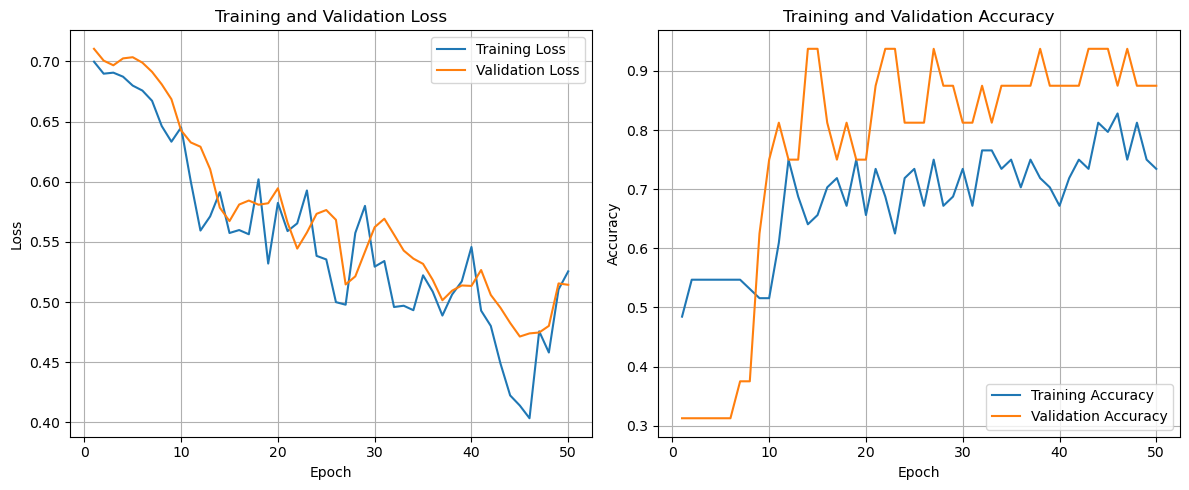

In [30]:
import matplotlib.pyplot as plt

# assuming these lists have one value per epoch
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_train, label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_train, label='Training Accuracy')
plt.plot(epochs, acc_val, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [32]:
torch.save(model, "Group_1_CNN_FullModel.ph")
print("Saved full model to: Group_1_CNN_FullModel.ph")

Saved full model to: Group_1_CNN_FullModel.ph
